# Projeto: Estilometria Aplicada aos Evangelhos: Uma Análise Computacional de Padrões de Escrita no Cristianismo Primitivo
Autor: Gabriel Severo  
Disciplina: Mineração de Dados e Aprendizado de Máquina

Bem-vindo(a), Neste notebook iremos realizar uma **análise estilométrica dos Evangelhos** — Mateus, Marcos, Lucas e João — utilizando técnicas de **Processamento de Linguagem Natural (NLP)** e **Aprendizado de Máquina (ML)**.

Nosso objetivo é identificar padrões de escrita e semelhanças estilísticas entre os textos bíblicos, explorando a fronteira entre **ciência de dados** e **estudos teológicos**.

## 🔧 Etapa 1 — Importações e Configuração do Ambiente
Nesta etapa inicial, vamos importar as bibliotecas que serão usadas ao longo do projeto.

📦 **Principais pacotes:**
- `nltk` e `spacy`: ferramentas de Processamento de Linguagem Natural (NLP);
- `scikit-learn`: usada para vetorização (TF-IDF), redução de dimensionalidade (PCA/SVD) e clustering (K-Means);
- `matplotlib` e `seaborn`: para visualização dos resultados.

💡 Após executar esta célula, o ambiente estará pronto para o restante do notebook.

In [ ]:
# Instalação das dependências necessárias
!pip install numpy pandas matplotlib seaborn scikit-learn nltk spacy

# Download do modelo de linguagem em português do spaCy
!python -m spacy download pt_core_news_sm

# Downloads dos recursos do NLTK
import nltk
nltk.download('punkt')
nltk.download('stopwords')

In [12]:
import os
import nltk
import spacy
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

nltk.download('punkt')
nltk.download('stopwords')
nlp = spacy.load('pt_core_news_sm')
stop_words = set(stopwords.words('portuguese'))

[nltk_data] Downloading package punkt to C:\Users\Gabriel
[nltk_data]     Severo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Gabriel
[nltk_data]     Severo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 📚 Etapa 2 — Coleta e Estruturação dos Dados
Agora vamos carregar os **textos dos evangelhos** e organizá-los para análise.

Cada evangelho será dividido em partes menores chamadas **_chunks_** (por exemplo, blocos de 500 palavras). Essa estratégia ajuda o modelo a comparar diferentes trechos dos textos, em vez de considerar cada livro inteiro de uma vez só.

In [13]:
def carregar_textos(path="data"):
    textos = {}
    for arquivo in os.listdir(path):
        if arquivo.endswith('.txt'):
            nome = arquivo.replace('.txt', '')
            with open(os.path.join(path, arquivo), 'r', encoding='utf-8') as f:
                textos[nome] = f.read()
    return textos

def chunk_text(text, words_per_chunk=1000):
    words = text.split()
    return [' '.join(words[i:i+words_per_chunk]) for i in range(0, len(words), words_per_chunk)]

textos = carregar_textos()
corpus, labels = [], []
for evangelho, texto in textos.items():
    chunks = chunk_text(texto)
    corpus.extend(chunks)
    labels.extend([evangelho] * len(chunks))
print(f"Total de trechos (chunks): {len(corpus)}")

Total de trechos (chunks): 389


## 🧹 Etapa 3 — Pré-processamento dos Textos
Antes de analisarmos o conteúdo, precisamos **limpar e normalizar os textos**.

Aqui faremos:
- Conversão para letras minúsculas;
- Remoção de pontuação, números e stopwords (palavras muito comuns, como “de”, “a”, “o”);
- Lematização (reduz palavras à sua forma base, ex: “falando” → “falar”).

O resultado será um texto mais “limpo” e uniforme, pronto para ser transformado em números nas próximas etapas.

In [14]:
def preprocess(text):
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if token.is_alpha and token.text not in stop_words]
    return ' '.join(tokens)

corpus_limpo = [preprocess(texto) for texto in corpus]
print("Exemplo de texto limpo:\n")
print(corpus_limpo[0][:500])

Exemplo de texto limpo:

princípio verbor verbo Deus verbo de eus princípio Deus todo coisa fazer nada fazer fazer em ele vida vida luz homem luz resplandecer treva treva compreender homem enviar Deus cujo nome João vir testemunho testificasse luz todo crer luz testificasse luz ali luz verdadeiro iluminar todo homem vir mundo mundo mundo fazer mundo conhecer vir receber todo quanto receber poder ser fazer filho Deus crêem nome qual nascer sangue vontade carne vontade homem Deus verbor fazer carne habitar vir glória glór


## 📊 Etapa 4 — Extração de Métricas Estilométricas
Agora que temos o texto limpo, podemos calcular **métricas que ajudam a capturar o estilo de escrita** de cada evangelho.

As principais métricas aqui serão:
- **Diversidade lexical**: quão variado é o vocabulário usado;
- **Comprimento médio das palavras**: textos com palavras mais longas tendem a ser mais formais;
- **Tamanho médio das sentenças**: pode indicar fluidez ou complexidade de estilo.

Essas informações são úteis para comparações iniciais entre os textos, antes de aplicar machine learning.

In [15]:
def calcular_metricas(tokens):
    total = len(tokens)
    unicos = len(set(tokens))
    diversidade = unicos / total if total > 0 else 0
    comprimento_medio = sum(len(t) for t in tokens) / total if total > 0 else 0
    return diversidade, comprimento_medio

metricas = []
for texto, evangelho in zip(corpus_limpo, labels):
    tokens = texto.split()
    diversidade, comprimento_medio = calcular_metricas(tokens)
    metricas.append({
        'evangelho': evangelho,
        'diversidade': diversidade,
        'comprimento_medio': comprimento_medio
    })
df_metricas = pd.DataFrame(metricas)
df_metricas.groupby('evangelho').mean()

,diversidade,comprimento_medio
evangelho,,
joao,0.468181,5.365006
lucas,0.572840,5.610573
marcos,0.573079,5.681598
mateus,0.546518,5.629256


## 🔡 Etapa 5 — Vetorização com TF-IDF
Agora transformamos o texto em **vetores numéricos**, que serão usados pelos algoritmos de aprendizado de máquina.

A técnica **TF-IDF (Term Frequency - Inverse Document Frequency)** mede a importância de cada palavra em um documento dentro do conjunto total.

👉 Palavras muito comuns em todos os textos (como “Jesus”) recebem peso baixo, enquanto termos mais específicos de um evangelho recebem peso alto.

In [16]:
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1,2), min_df=3)
X = vectorizer.fit_transform(corpus_limpo)
print(f"Matriz TF-IDF: {X.shape}")

Matriz TF-IDF: (389, 1000)


## 🧠 Etapa 6 — Redução de Dimensionalidade e Clustering (K-Means)
Os vetores TF-IDF possuem milhares de dimensões (palavras), então reduzimos a dimensionalidade usando **TruncatedSVD**, uma variação do PCA.

Depois, aplicamos **K-Means**, um método de aprendizado não supervisionado que agrupa textos semelhantes.

📈 O **Silhouette Score** será usado para medir a qualidade dos agrupamentos — quanto mais próximo de 1, melhor a separação entre os clusters.

In [17]:
svd = TruncatedSVD(n_components=50, random_state=42)
X_reduced = svd.fit_transform(X)
kmeans = KMeans(n_clusters=4, random_state=42)
labels_pred = kmeans.fit_predict(X_reduced)
score = silhouette_score(X_reduced, labels_pred)
print(f"Silhouette Score: {score:.3f}")

Silhouette Score: 0.078


## 🎨 Etapa 7 — Visualização dos Clusters
Vamos visualizar os agrupamentos formados pelos textos. Usaremos o **PCA 2D** para reduzir os vetores a duas dimensões e gerar um gráfico.

- Cada ponto representa um *chunk* (trecho de texto), e a cor representa o grupo (cluster) ao qual ele pertence.

Com isso, conseguimos observar se os evangelhos se agrupam de maneira distinta com base no estilo de escrita.

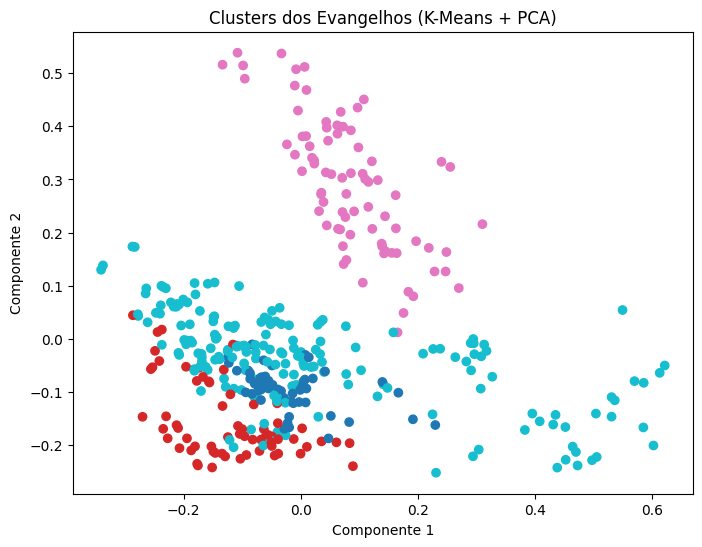

In [22]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_reduced)
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_pred, cmap='tab10')
plt.title('Clusters dos Evangelhos (K-Means + PCA)')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.show()

## 🪶 Etapa 8 — Palavras Representativas de Cada Cluster
Agora, vamos identificar as **palavras mais importantes** (segundo o TF-IDF) de cada grupo encontrado pelo K-Means.

Isso ajuda a interpretar o que diferencia os estilos entre clusters. Por exemplo, pode ser que um grupo use mais termos teológicos, enquanto outro use mais expressões narrativas.

In [19]:
terms = vectorizer.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
for i in range(kmeans.n_clusters):
    top_terms = [terms[ind] for ind in order_centroids[i, :10]]
    print(f"\nCluster {i}: {' | '.join(top_terms)}")


Cluster 0: abençoar | abrir olho | acabar | acontecer | aldeia | ai | alma | algum | alguém | altar

Cluster 1: abençoar | abrir | alto | alto voz | aparecer | algum | apanhar | alguém | ai | ajuntar

Cluster 2: abençoar | abraão | abertamente | abrir | abrir olho | adiante | acusar | algum coisa | ainda falar | amigo

Cluster 3: abençoar | acerca | acrescentar | admirar | ainda | abertamente | achar | adorar | acontecer | ainda outro


## 💾 Etapa 9 — Análise Final e Considerações
Para encerrar o notebook, vamos visualizar rapidamente as **médias de diversidade lexical** calculadas antes.

Essa métrica é útil para ver se algum evangelho se destaca por usar vocabulário mais amplo ou restrito.

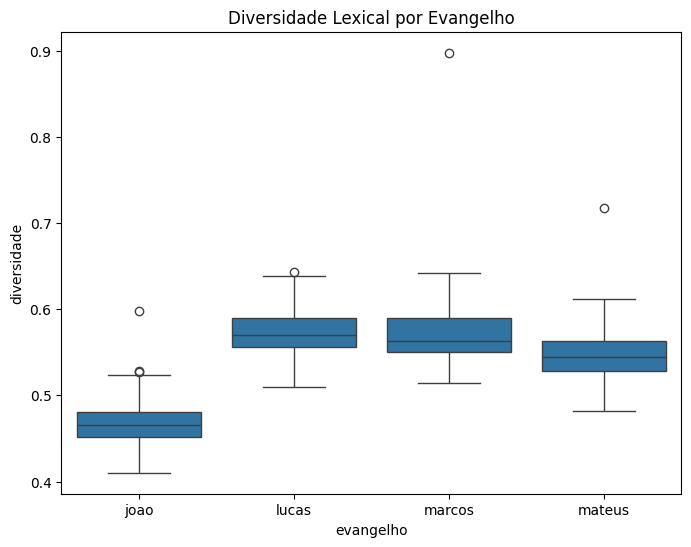

In [20]:
df_metricas['cluster'] = labels_pred
os.makedirs('results', exist_ok=True)
df_metricas.to_csv('results/metricas_clusters.csv', index=False)
plt.figure(figsize=(8,6))
sns.boxplot(data=df_metricas, x='evangelho', y='diversidade')
plt.title('Diversidade Lexical por Evangelho')
plt.show()

## ✅ Conclusão

🔍 **O que foi feito:**
- Limpeza e pré-processamento dos textos dos evangelhos;
- Extração de métricas estilométricas básicas;
- Representação vetorial com TF-IDF;
- Agrupamento (clustering) e visualização com K-Means e PCA;
- Interpretação dos resultados e comparação de estilos.